In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
from rdkit import Chem
from dfs_transformer.utils import Mol2Smiles, DFSCode2Graph, Graph2Mol, isValid, Smiles2DFSCode, DFSCode2Smiles, isValidMoleculeDFSCode
from dfs_transformer.utils import DFSCode2Graph, Smiles2DFSCode, load_selfattn_wandb, load_selfattn_local
import os.path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import dfs_transformer as dfs
import numpy as np
from ml_collections import ConfigDict
import yaml
import functools
import tqdm
import traceback
from matplotlib import pyplot as plt
import pandas as pd
import networkx as nx

In [2]:
import chemprop.features
import chemprop

In [3]:
chemprop.__version__

'1.3.1'

In [9]:
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   formal_charge=atom.GetFormalCharge(),
                   chiral_tag=atom.GetChiralTag(),
                   hybridization=atom.GetHybridization(),
                   num_total_hs=atom.GetTotalNumHs(),
                   is_aromatic=atom.GetIsAromatic())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
    return G

def nx_to_mol(G):
    mol = Chem.RWMol()
    atomic_nums = nx.get_node_attributes(G, 'atomic_num')
    chiral_tags = nx.get_node_attributes(G, 'chiral_tag')
    formal_charges = nx.get_node_attributes(G, 'formal_charge')
    node_is_aromatics = nx.get_node_attributes(G, 'is_aromatic')
    node_hybridizations = nx.get_node_attributes(G, 'hybridization')
    num_total_hs = nx.get_node_attributes(G, 'num_total_hs')
    node_to_idx = {}
    for node in G.nodes():
        a=Chem.Atom(atomic_nums[node])
        a.SetChiralTag(chiral_tags[node])
        a.SetFormalCharge(formal_charges[node])
        a.SetIsAromatic(node_is_aromatics[node])
        a.SetHybridization(node_hybridizations[node])
        idx = mol.AddAtom(a)
        node_to_idx[node] = idx

    bond_types = nx.get_edge_attributes(G, 'bond_type')
    for edge in G.edges():
        first, second = edge
        ifirst = node_to_idx[first]
        isecond = node_to_idx[second]
        bond_type = bond_types[first, second]
        mol.AddBond(ifirst, isecond, bond_type)
    
    # this is a workaround because we precomputed num_total_hs in the existing pipeline.
    # so using this we avoid touching the feature extraction 
    mol.UpdatePropertyCache()
    for node in G.nodes():
        a = mol.GetAtomWithIdx(node_to_idx[node])
        a.SetNumExplicitHs(num_total_hs[node] - a.GetNumImplicitHs())

    Chem.SanitizeMol(mol)
    return mol

In [10]:
df = pd.read_csv("/mnt/ssd/datasets/moses/data/dataset_v1.csv")

In [11]:
smiles = df['SMILES']

In [12]:
sml = 'Cc1[nH]cnc1Cc1nc(-c2ccccc2)cs1'
mol = Chem.MolFromSmiles(sml)
atoms = list(mol.GetAtoms())
atom_types = [a.GetAtomicNum() for a in atoms]
valences = [a.GetTotalValence() for a in atoms]
charge = [a.GetFormalCharge() for a in atoms]
explicitHs = [a.GetNumExplicitHs() for a in atoms]
implicitHs = [a.GetNumImplicitHs() for a in atoms]

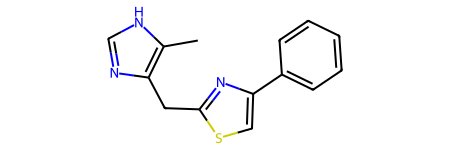

In [13]:
nx_to_mol(mol_to_nx(mol))

In [14]:
print(atom_types)
print(explicitHs)
print(implicitHs)
print(valences)
print(charge)

[6, 6, 7, 6, 7, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 16]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]
[4, 4, 3, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [15]:
invalid_smiles = []
for sml in tqdm.tqdm(smiles[:10000]):
    try:
        mol = Chem.MolFromSmiles(sml)
        mol2 = nx_to_mol(mol_to_nx(mol))
        if Chem.MolToSmiles(mol) != Chem.MolToSmiles(mol2):
            raise Exception('molecule changes')
    except:
        print(sml)
        invalid_smiles += [sml]    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1165.99it/s]


In [16]:
invalid_smiles

[]

valid_list = []
invalid_smiles = []
for sml in tqdm.tqdm(smiles[:1000]):
    code, index = Smiles2DFSCode(sml)
    try:
        valid_list += [isValidMoleculeDFSCode(code, verbose=True)]
    except Exception as e:
        valid_list += [False]
        traceback.print_exc()
    if not valid_list[-1]:
        invalid_smiles += [sml]
print(sum(valid_list)/len(valid_list))

invalid_smiles

dfs.utils.Smiles2Mol('Cc1ccc(c2n[nH]c(=S)n2CC(=O)Nc2ccc(C)c([N+](=O)[O-])c2)cc1\n')

code, index = dfs.utils.Smiles2DFSCode('Cc1ccc(c2n[nH]c(=S)n2CC(=O)Nc2ccc(C)c([N+](=O)[O-])c2)cc1\n')
dfs.utils.Graph2Mol(*dfs.utils.DFSCode2Graph(code))